## LR
- 前処理を以下の方法で設定

    - ChestPainType:TAとNAPをTA+NAPにまとめる
    - ST_SlopのFlatとDownをまとめる(FlatとDownの分布が似ている、Downの数が少ない)
    - カテゴリ-変数はOneHotEncoding
    - コレステロール0のデータを区別したいためchol0の特徴量を追加
    - 連続値データは標準化
    - <b>Oldpeak,STSlopを基に特徴量を作成(性別は統合しない)</b>
    - <b>cholesterolと安静時のパラメータ関連で特徴量を作れないか検討</b>
    - <b>ChestPainTypeのTA,ATAが生かせないか検討</b>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#データ取得
df_train = pd.read_csv("../main/data/train.csv")
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


-Oldpeak,Sex,ST_Slopeで以下の特徴量(H_risk)を作成。元の特徴量は使用しない。<br>
Oldpeakは絶対値で判断<br>
ラベル番号はリスク高い方が大きい<br>
0: Abs(Oldpeak)<0.3 かつST_Slope=Up<br>
2: Abs(Oldpeak)<0.3 かつST_Slope=Flat,Down<br>
1: 0.3=<Abs(Oldpeak)<2.5 かつST_Slope=Up<br>
3: 0.3=<Abs(Oldpeak)<2.5 かつST_Slope=Flat,Down<br>
4: Abs(Oldpeak)>2.5<br>

In [4]:
#特徴量作成
df_train['H_risk']='Risk0'
for i in range(len(df_train)):
    if abs(df_train.loc[i,'Oldpeak'])<0.3 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk2'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.5 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='Risk1'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.5 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk3'
    elif abs(df_train.loc[i,'Oldpeak'])>=2.5:
        df_train.loc[i,'H_risk']='Risk4'
    else:
        pass
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,Risk4
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0,Risk0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,Risk2
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,Risk0


In [14]:
#TAとATAをTA+ATAとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_train.loc[df_train['ChestPainType']=='TA','ChestPainType']='TA+ATA'
df_train.loc[df_train['ChestPainType']=='ATA','ChestPainType']='TA+ATA'

In [19]:
#ChestPainTypeとcholesterolでカテゴリー変数作成
df_train['cpt+chol']=0
for i in range(len(df_train)):
    if df_train.loc[i,'Cholesterol']>=290 and df_train.loc[i,'ChestPainType']=='TA+ATA':
        df_train.loc[i,'cpt+chol']=1
    elif df_train.loc[i,'RestingBP']>=150 and df_train.loc[i,'ChestPainType']=='TA+ATA':
        df_train.loc[i,'cpt+chol']=1
    elif df_train.loc[i,'RestingECG']=='ST' and df_train.loc[i,'ChestPainType']=='TA+ATA':
        df_train.loc[i,'cpt+chol']=1
    elif df_train.loc[i,'RestingECG']=='LVH' and df_train.loc[i,'ChestPainType']=='TA+ATA':
        df_train.loc[i,'cpt+chol']=1
    elif df_train.loc[i,'MaxHR']>=150 and df_train.loc[i,'ChestPainType']=='TA+ATA':
        df_train.loc[i,'cpt+chol']=1
    
pd.crosstab(df_train['cpt+chol'],df_train['HeartDisease'])

HeartDisease,0,1
cpt+chol,,
0,188,343
1,95,16


In [20]:
#心臓病有り無しで分けて表示
df_train_0 = df_train.query('HeartDisease==0')
df_train_1 = df_train.query('HeartDisease==1')

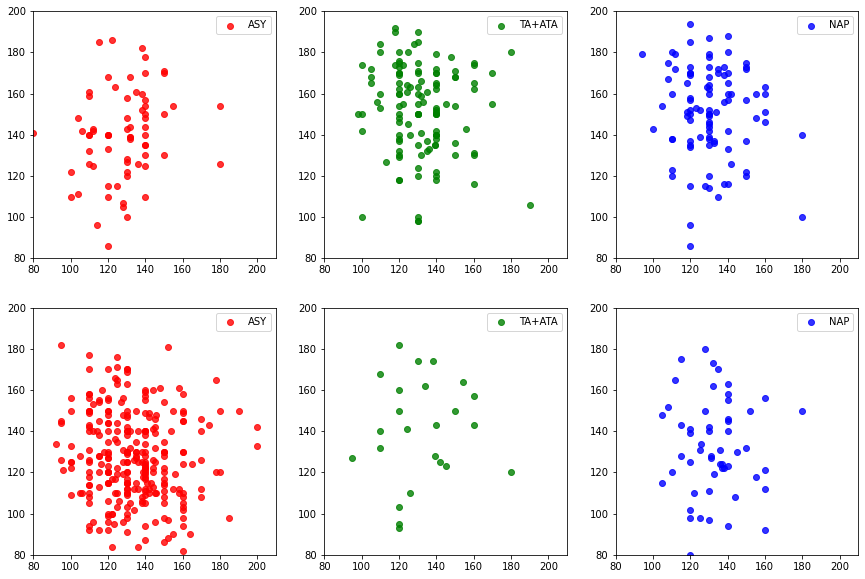

In [18]:
fig=plt.figure(figsize=(20,10))

color_list=['r','g','b','c','m']
for i,labels in enumerate(['ASY','TA+ATA','NAP']):
    ax=fig.add_subplot(2,4,i+1,xlim=[80,210],ylim=[80,200])
    ax=plt.scatter(df_train_0.loc[df_train_0['ChestPainType']==labels,'RestingBP'],df_train_0.loc[df_train_0['ChestPainType']==labels,'MaxHR'],c=color_list[i],label=labels,alpha=0.8)
    plt.legend()
for i,labels in enumerate(['ASY','TA+ATA','NAP']):
    ax=fig.add_subplot(2,4,i+5,xlim=[80,210],ylim=[80,200])
    ax2=plt.scatter(df_train_1.loc[df_train_1['ChestPainType']==labels,'RestingBP'],df_train_1.loc[df_train_1['ChestPainType']==labels,'MaxHR'],c=color_list[i],label=labels,alpha=0.8)
    plt.legend()

plt.show()

In [8]:
pd.crosstab(df_train['ChestPainType'],df_train['RestingECG'])

RestingECG,LVH,Normal,ST
ChestPainType,,,
ASY,68,206,76
ATA,13,89,20
NAP,33,91,25
TA,7,11,3


In [9]:
pd.crosstab(df_train_0['ChestPainType'],df_train_0['RestingECG'])

RestingECG,LVH,Normal,ST
ChestPainType,,,
ASY,12,43,14
ATA,9,80,16
NAP,25,59,11
TA,6,5,3


In [10]:
pd.crosstab(df_train_1['ChestPainType'],df_train_1['RestingECG'])

RestingECG,LVH,Normal,ST
ChestPainType,,,
ASY,56,163,62
ATA,4,9,4
NAP,8,32,14
TA,1,6,0


In [5]:
#chestpaintypeとの関係を確認

pd.crosstab(df_train['H_risk'],df_train['ChestPainType'])

ChestPainType,ASY,ATA,NAP,TA
H_risk,,,,
Risk0,54,84,61,6
Risk1,33,13,16,5
Risk2,56,6,17,3
Risk3,157,17,47,5
Risk4,50,2,8,2


In [6]:
pd.crosstab(df_train_0['H_risk'],df_train_0['ChestPainType'])

ChestPainType,ASY,ATA,NAP,TA
H_risk,,,,
Risk0,39,83,58,6
Risk1,9,11,14,3
Risk2,2,2,1,2
Risk3,18,9,20,3
Risk4,1,0,2,0


In [7]:
pd.crosstab(df_train_1['H_risk'],df_train_1['ChestPainType'])

ChestPainType,ASY,ATA,NAP,TA
H_risk,,,,
Risk0,15,1,3,0
Risk1,24,2,2,2
Risk2,54,4,16,1
Risk3,139,8,27,2
Risk4,49,2,6,2


## Risk毎に比較してみる

* Risk0: ATA,NAPが多い、ASYは少ない・・・胸が痛くても運動のテストでは問題が無い人がほとんど
* Risk1: ASYで心臓病の率が高い、ATA,NAPは低い
* Risk2: ASYが多い。心臓病の率はNAPもASYも高い。ATAは微妙
* Risk3: ASY,NAPが多い。ASYは心臓病率が高く、ATA,TAは低い,
* Risk4: どれも高そう、判断むずいが,NAPよりかはASYが高い。

## ASYの方が血糖値高い？？

In [9]:
pd.crosstab(df_train['FastingBS'],df_train['ChestPainType'])

ChestPainType,ASY,ATA,NAP,TA
FastingBS,,,,
0,243,107,118,15
1,107,15,31,6


In [10]:
pd.crosstab(df_train_0['FastingBS'],df_train_0['ChestPainType'])

ChestPainType,ASY,ATA,NAP,TA
FastingBS,,,,
0,63,96,81,12
1,6,9,14,2


In [11]:
pd.crosstab(df_train_1['FastingBS'],df_train_1['ChestPainType'])

ChestPainType,ASY,ATA,NAP,TA
FastingBS,,,,
0,180,11,37,3
1,101,6,17,4


* ASYかつ高血糖だと心臓病の率が他より高い


In [13]:
## 血糖とRiskの関係
pd.crosstab(df_train['H_risk'],df_train['FastingBS'])

FastingBS,0,1
H_risk,,
Risk0,183,22
Risk1,46,21
Risk2,52,30
Risk3,154,72
Risk4,48,14


In [14]:
pd.crosstab(df_train_0['H_risk'],df_train_0['FastingBS'])

FastingBS,0,1
H_risk,,
Risk0,168,18
Risk1,31,6
Risk2,6,1
Risk3,45,5
Risk4,2,1


In [15]:
pd.crosstab(df_train_1['H_risk'],df_train_1['FastingBS'])

FastingBS,0,1
H_risk,,
Risk0,15,4
Risk1,15,15
Risk2,46,29
Risk3,109,67
Risk4,46,13


## Risk0-3に対してはFastingBSは効果的、Risk4では血糖値が低くても心電図の影響が支配的なので意味ない
→改善代1

In [17]:
pd.crosstab(df_train['H_risk'],df_train['ExerciseAngina'])

ExerciseAngina,0,1
H_risk,,
Risk0,191,14
Risk1,50,17
Risk2,57,25
Risk3,78,148
Risk4,16,46


In [23]:
pd.crosstab(df_train_0['H_risk'],df_train_0['ExerciseAngina'])

ExerciseAngina,0,1
H_risk,,
Risk0,175,11
Risk1,35,2
Risk2,5,2
Risk3,32,18
Risk4,2,1


In [24]:
pd.crosstab(df_train_1['H_risk'],df_train_1['ExerciseAngina'])

ExerciseAngina,0,1
H_risk,,
Risk0,16,3
Risk1,15,15
Risk2,52,23
Risk3,46,130
Risk4,14,45


## Risk1,Risk3,Risk4に対しては効果あり(Oldpeakが0で無い時)
→改善代2

## FastingBSとRestingBPとコレステロールの関係

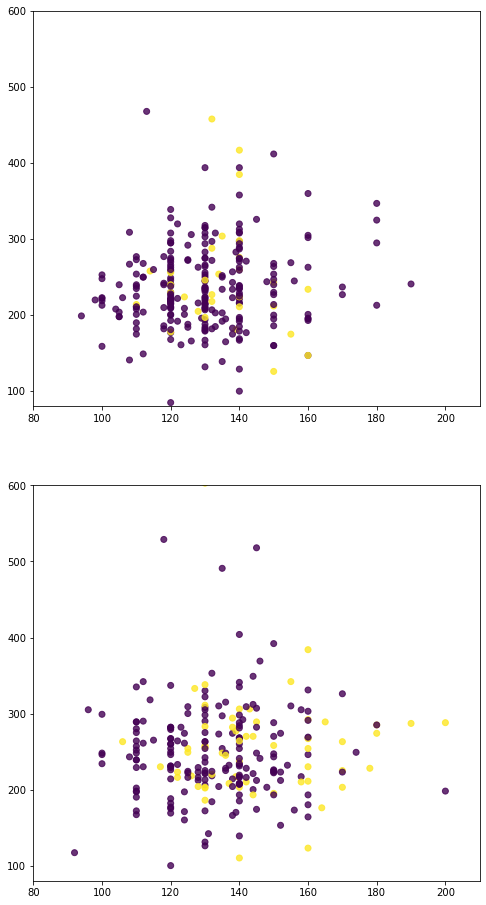

In [38]:
fig=plt.figure(figsize=(8,16))

ax1=fig.add_subplot(2,1,1,xlim=[80,210],ylim=[80,600])
ax1=plt.scatter(df_train_0['RestingBP'],df_train_0['Cholesterol'],c=df_train_0['FastingBS'],label='0',alpha=0.8)

ax2=fig.add_subplot(2,1,2,xlim=[80,210],ylim=[80,600])
ax2=plt.scatter(df_train_1['RestingBP'],df_train_1['Cholesterol'],c=df_train_1['FastingBS'],label='1',alpha=0.8)

plt.show()

In [39]:
## コレステロール値が中盤のグループ、およびRestingBPが120~130より高いグループはFastingBSがあると心臓病率が上がりがち

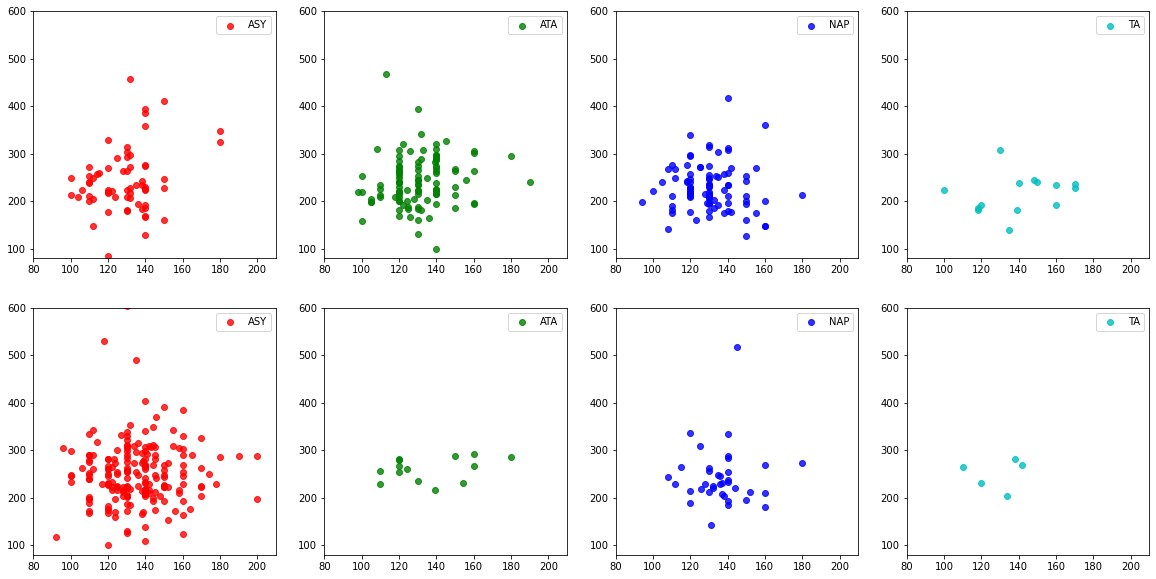

In [51]:
fig=plt.figure(figsize=(20,10))

color_list=['r','g','b','c','m']
for i,labels in enumerate(['ASY','ATA','NAP','TA']):
    ax=fig.add_subplot(2,4,i+1,xlim=[80,210],ylim=[80,600])
    ax=plt.scatter(df_train_0.loc[df_train_0['ChestPainType']==labels,'RestingBP'],df_train_0.loc[df_train_0['ChestPainType']==labels,'Cholesterol'],c=color_list[i],label=labels,alpha=0.8)
    plt.legend()
for i,labels in enumerate(['ASY','ATA','NAP','TA']):
    ax=fig.add_subplot(2,4,i+5,xlim=[80,210],ylim=[80,600])
    ax2=plt.scatter(df_train_1.loc[df_train_1['ChestPainType']==labels,'RestingBP'],df_train_1.loc[df_train_1['ChestPainType']==labels,'Cholesterol'],c=color_list[i],label=labels,alpha=0.8)
    plt.legend()

plt.show()

## ASYはBP高めのデータが多い、TA,ATAかつコレステロール低いと心臓病は無し？
## ATAかつ血圧300越えも心臓病ではない

日本では500人に1人位の高頻度でみられる「家族性高コレステロール血症」という、遺伝性の高コレステロール血症があります

https://www.hyogo.med.or.jp/health-care/044%E3%80%80%E9%AB%98%E3%82%B3%E3%83%AC%E3%82%B9%E3%83%86%E3%83%AD%E3%83%BC%E3%83%AB%E8%A1%80%E7%97%87%E5%AE%B6%E6%97%8F%E6%80%A7%E3%81%A8%E6%8C%87%E6%91%98%E3%81%95%E3%82%8C%E3%81%9F%E3%82%89/

予想：
この症状がある人は狭心症の症状があって、すでに治療を開始している。高コレステロール値かつ狭心症の症状がある人は治療済み？また、狭心症の症状がある人の中でもコレステロールが正常値(200以下)まで下がっている人も治療済み
→改善点4

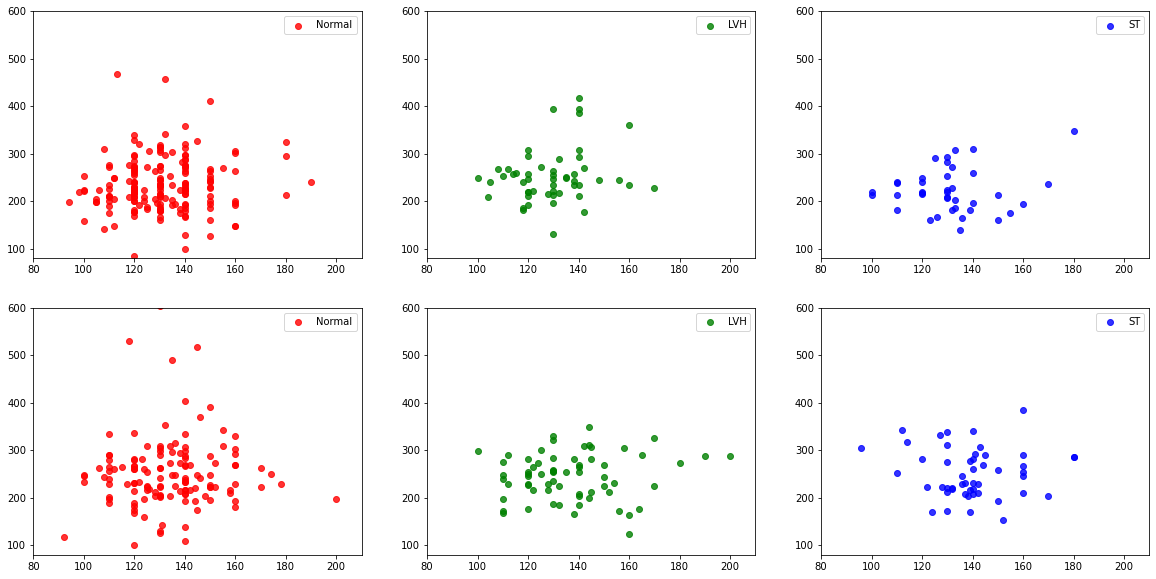

In [54]:
fig=plt.figure(figsize=(20,10))

for i,labels in enumerate(['Normal','LVH','ST']):
    ax=fig.add_subplot(2,3,i+1,xlim=[80,210],ylim=[80,600])
    ax=plt.scatter(df_train_0.loc[df_train_0['RestingECG']==labels,'RestingBP'],df_train_0.loc[df_train_0['RestingECG']==labels,'Cholesterol'],c=color_list[i],label=labels,alpha=0.8)
    plt.legend()
for i,labels in enumerate(['Normal','LVH','ST']):
    ax=fig.add_subplot(2,3,i+4,xlim=[80,210],ylim=[80,600])
    ax2=plt.scatter(df_train_1.loc[df_train_1['RestingECG']==labels,'RestingBP'],df_train_1.loc[df_train_1['RestingECG']==labels,'Cholesterol'],c=color_list[i],label=labels,alpha=0.8)
    plt.legend()


plt.show()

In [55]:
pd.crosstab(df_train['RestingECG'],df_train['HeartDisease'])

HeartDisease,0,1
RestingECG,,
LVH,52,69
Normal,187,210
ST,44,80


In [56]:
## STのみに着目しても良さそう、診断的にもSTが狭心症に直接効いてくるし